In [199]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

%matplotlib inline

In [200]:
####Clean data####
#create empty dataframe to be filled with all the values
column_names = ['obs','Y','X1','X2','database']
data = pd.DataFrame(columns = column_names)

#extract data from each excel sheet and append to data frame
for s in range(72):
    df = pd.read_excel('PS1_Q5_Data.xlsx',sheet_name= 'DataSet'+str(s))
    df['database'] = s
    df.columns = column_names
    data = pd.concat([data,df], ignore_index=True)
    del df

In [201]:
#Creates database with estimates from the pre-testing procedure
#Additionally it estimates the parameters μ_1, μ_2, ρ, σ_1, and σ_2

#create empty data frame that contains values
column_names = ['sample','beta','beta_se','model','mu_1','mu_2','rho','sigma_1','sigma_2','sigma_e']
result_summary = pd.DataFrame(columns = column_names)

for i in range(72):
    
    df = data[data['database']==i]
    X = df[['X1','X2']]

    ##calculate mean and covariance parameters
    μ_1,μ_2 = np.mean(X)[0],np.mean(X)[1]
    Σ = np.cov(X.T)
    σ_1 = np.sqrt(Σ[0,0])
    σ_2 = np.sqrt(Σ[1,1])
    ρ = Σ[0,1]/(σ_1*σ_2)
    
    
    ##pretesting produre
    #Long regression
    X = sm.add_constant(X)
    y = df['Y']

    model = sm.OLS(y, X)
    results = model.fit()
    model_t = 0
    σ_ε = float(np.cov(results.resid))

    if results.tvalues[2]<1.964:
        
        #short regression
        X = df[['X1']]
        X = sm.add_constant(X)
        y = df['Y']
        
        model = sm.OLS(y, X)
        results = model.fit()
        model_t = 1
        
    β = results.params[1]
    β_SE = results.bse[1]

    df = pd.DataFrame(np.array([i, β, β_SE, model_t, μ_1, μ_2, ρ, σ_1, σ_2, σ_ε])).T
    df.columns = column_names
    result_summary = pd.concat([result_summary,df], ignore_index=True)
    

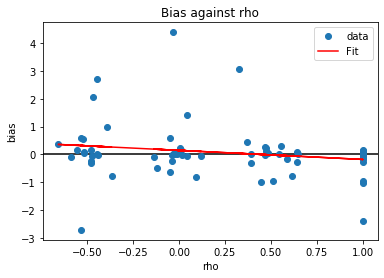

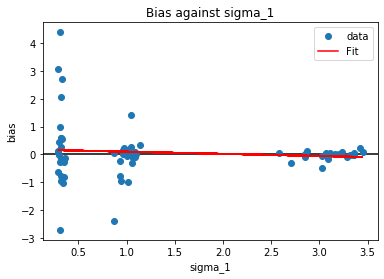

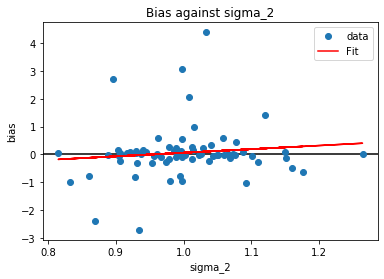

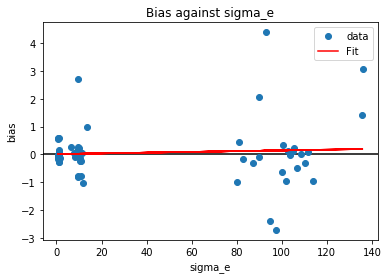

In [202]:
result_summary['bias'] = result_summary['beta'] - 1

x_list = ['rho','sigma_1','sigma_2','sigma_e']

for x_name in x_list:
    X = result_summary[x_name]
    y = result_summary['bias']
    
    #regression for line of best fit
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    α, β = results.params[0], results.params[1]
    y_fit = [α + β*v for v in X]
    
    fig, ax = plt.subplots()
    plt.axhline(0, color='black')
    ax.plot(X,y, 'o', label="data")
    ax.plot(X, y_fit, 'r-', label="Fit")
    ax.set_title('Bias against '+ x_name)
    ax.set_xlabel(x_name)
    ax.set_ylabel('bias')
    ax.legend(loc='best')

    plt.show()

